<a href="https://colab.research.google.com/github/Loinen/datagen/blob/main/SDVmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загружаем либы

In [1]:
!pip install sdv
!pip uninstall numpy
!pip install numpy

Uninstalling numpy-1.20.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.20.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libopenblasp-r0-5bebc122.3.13.dev.so
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/numpy/*
Proceed (y/n)? ERROR: Operation cancelled by user
^C
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistIn

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import random as rd

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score,  plot_roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn import model_selection
from sklearn.metrics import classification_report, plot_confusion_matrix

In [4]:
from sdv.timeseries import PAR

# Загружаем данные

In [7]:
#data = pd.read_csv("base25data/Shestakovo_validation2.csv", index_col=0)
data = pd.read_csv("Shestakovo_validation2.csv", index_col=0)
data.LITHO = data.LITHO.astype('int8') # data.LITHO.astype('category')

In [19]:
print(data.LITHO.value_counts())
print(len(data.Well.unique()))

0    137414
1     65685
Name: LITHO, dtype: int64
990


In [8]:
train_part_size = 0.7
rd.seed(17)
train_wells = rd.sample(data.Well.unique().tolist(), round(len(data.Well.unique())*train_part_size))
train_set = data.loc[data.Well.isin(train_wells)]
test_set = data.loc[data.Well.isin(i for i in data.Well.unique() if i not in train_wells)]

Feature_train = train_set.drop(['DEPT', 'Well', 'LITHO'], axis=1)
Target_train = train_set['LITHO']
Feature_test = test_set.drop(['DEPT', 'Well', 'LITHO'], axis=1)
Target_test = test_set['LITHO']

In [9]:
# baseline
clf = RandomForestClassifier(class_weight="balanced")
clf.fit(Feature_train, Target_train)
predicted_litho = clf.predict(Feature_test)

# F1 и Accuracy
base_acc = accuracy_score(Target_test, predicted_litho)
base_f1 = f1_score(Target_test, predicted_litho)
print('F1 метрика равна %.3f, и доля правильных ответов составляет %.3f'%(base_f1, base_acc))

F1 метрика равна 0.883, и доля правильных ответов составляет 0.925


In [11]:
# PAR model

entity_columns = ['Well']
sequence_index = 'DEPT'

model = PAR(
    entity_columns=entity_columns,
    sequence_index=sequence_index,
)

model.fit(train_set)  # учим на том же, на чем учили RF
model.save('par_base_kn_l200.pkl')

In [47]:
# model = PAR.load('par_base_kn_l200.pkl')
new_data = model.sample(1100)  # ~140k #470, sequence_length=300
new_data.to_csv('par_results_noSl.csv', index=False)

In [ ]:
# new_data = pd.read_csv("par_results_200_no_ns.csv", index_col=False)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 8 Text major ticklabel objects>)

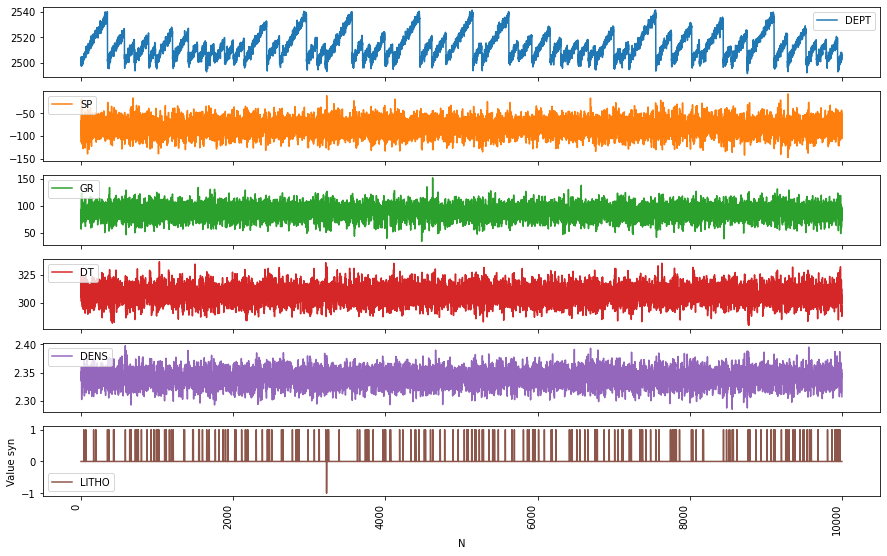

In [48]:
# отрисуем полученные данные
new_data[:10000].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value syn")
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')

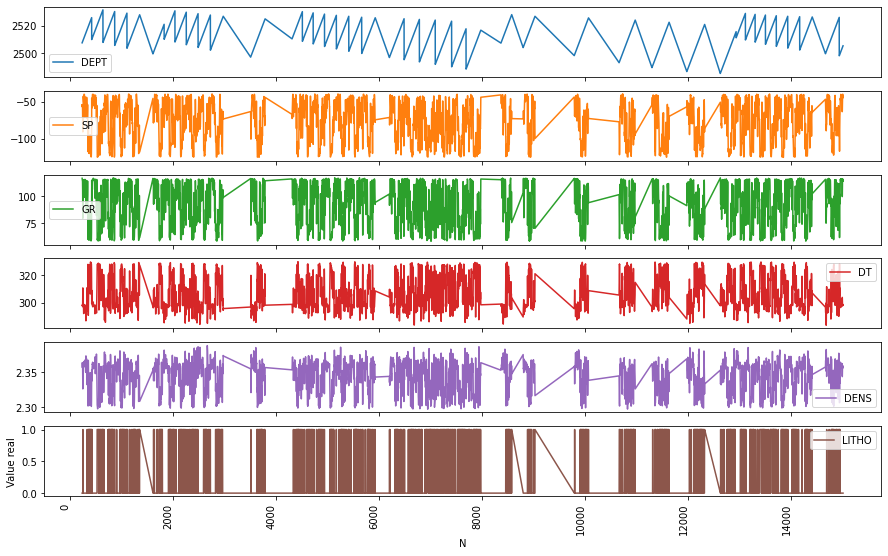

In [49]:
# отрисуем обучающие данные
train_set[:10000].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value real")
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [55]:
print(new_data.shape)
print(new_data.head())

(215506, 7)
          DEPT          SP         GR          DT      DENS  LITHO Well
0  2497.876634  -77.341844  78.950623  307.133987  2.338177      0    a
1  2500.967884  -67.180119  78.752119  307.133987  2.348405      0    a
2  2497.721234  -94.624296  57.373060  306.864266  2.342281      0    a
3  2504.487272  -79.537293  89.173647  330.963997  2.349175      0    a
4  2500.965863 -113.463567  93.889975  304.238388  2.351931      0    a


In [54]:
new_data = new_data.drop(np.where(new_data['LITHO'] > 1)[0])
new_data = new_data.replace(-1, np.nan, regex=True)
new_data = new_data.dropna(subset=['LITHO'])

new_data.LITHO = new_data.LITHO.values.astype('bool')  # костыль
new_data.LITHO = new_data.LITHO.values.astype('int')
pd.set_option('display.max_columns', 15)
print(train_set.describe())
print(new_data.describe())

par_feature_train = new_data.drop(['DEPT', 'Well', 'LITHO'], axis=1)
par_target_train = new_data['LITHO']
print("new shape", new_data.shape)

print(par_target_train.value_counts('LITHO'))
print(train_set.value_counts('LITHO'))
print("test", test_set.value_counts('LITHO'))

                DEPT             SP             GR             DT  \
count  140747.000000  140747.000000  140747.000000  140747.000000   
mean     2514.213044     -77.341844      90.912409     307.133987   
std         9.174623      27.579643      19.792583      11.685418   
min      2485.100000    -125.710487      57.918972     283.431244   
25%      2508.100000    -102.076557      71.817993     297.886703   
50%      2515.000000     -72.711342      93.466705     303.080139   
75%      2521.100000     -52.234331     111.023235     316.672440   
max      2543.400000     -38.943268     116.989639     330.196503   

                DENS          LITHO  
count  140747.000000  140747.000000  
mean        2.342281       0.323112  
std         0.022178       0.467667  
min         2.295403       0.000000  
25%         2.324151       0.000000  
50%         2.349464       0.000000  
75%         2.359794       1.000000  
max         2.389950       1.000000  
                DEPT             SP 

In [52]:
sample_weight = par_target_train.shape[0]/(2*np.bincount(par_target_train))

rf = {"clf__criterion":["gini", "entropy"], "clf__max_depth": range(2,8,2),
           #"clf__class_weight":[{0:1, 1:75}, {0:1, 1:65}, {0:1, 1:70}],
           "clf__min_samples_leaf": range(1,5,1), "clf__n_estimators":range(50,90,20)
      }

pipe = Pipeline(steps=[ ('scaler', MinMaxScaler()),
                            ('clf', RandomForestClassifier(random_state=42))
                      ])
grid_cv = model_selection.GridSearchCV(pipe, rf, scoring='roc_auc')
grid_cv.fit(par_feature_train, par_target_train, clf__sample_weight=sample_weight[par_target_train])
print("model best score: ", grid_cv.best_score_)
print(grid_cv.best_params_)
clf_par = grid_cv.best_estimator_

model best score:  0.5394774837040068
{'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 50}


In [53]:
par_prediction = clf_par.predict(Feature_test)
user_acc = accuracy_score(Target_test, par_prediction)
user_f1 = f1_score(Target_test, par_prediction)
print('F1 метрика равна %.3f, и доля правильных ответов составляет %.3f для сген.данных.'%
      (user_f1, user_acc))

F1 метрика равна 0.593, и доля правильных ответов составляет 0.687 для сген.данных.


In [ ]:
# отрисуем полученные данные (1000)
new_data[:5000].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value syn")
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# отрисуем полученные данные (1000)
new_data[:300].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value syn")
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [56]:
print(classification_report(par_prediction, Target_test))
print(classification_report(predicted_litho, Target_test))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75     34494
           1       0.71      0.51      0.59     27858

    accuracy                           0.69     62352
   macro avg       0.69      0.67      0.67     62352
weighted avg       0.69      0.69      0.68     62352

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     42455
           1       0.88      0.89      0.88     19897

    accuracy                           0.92     62352
   macro avg       0.91      0.92      0.91     62352
weighted avg       0.93      0.92      0.92     62352



In [57]:
print("roc_auc real data ", roc_auc_score(Target_test, predicted_litho),
      "roc_auc syn data ", roc_auc_score(Target_test, par_prediction))

roc_auc real data  0.9121362206627386 roc_auc syn data  0.6915759472781479


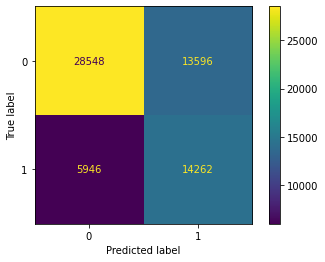

In [58]:
plot_confusion_matrix(clf_par, Feature_test, Target_test, values_format='d')

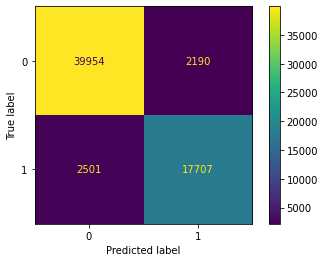

In [31]:
plot_confusion_matrix(clf, Feature_test, Target_test, values_format='d')

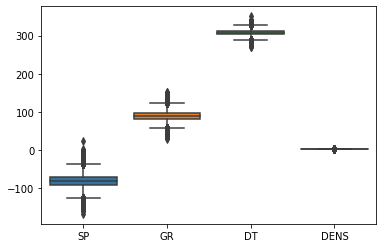

In [59]:
sns.boxplot(data=new_data[["SP", "GR", "DT", "DENS"]])

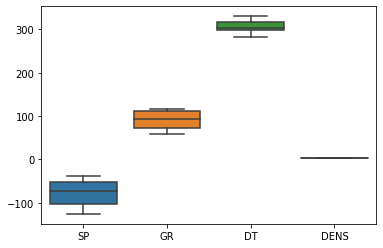

In [60]:
sns.boxplot(data=train_set[["SP", "GR", "DT", "DENS"]])

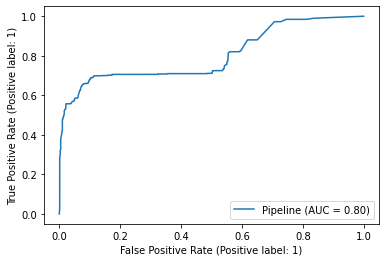

In [61]:
plot_roc_curve(clf_par, Feature_test, Target_test)

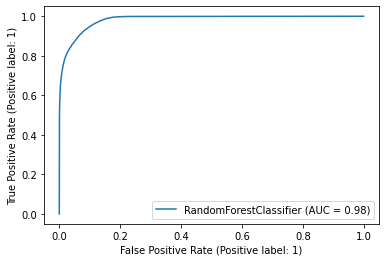

In [45]:
plot_roc_curve(clf, Feature_test, Target_test)